Processing file: output/sinData_fir.txt
{'file_name': 'sinData_fir.txt', 'contains_Complex': False, 'contains_LUT': False, 'OSR': 8.0, 'complex': 0.0, 'fs': 10000.0}
1
1
Saved spectrum plot to ./figs/sinData_fir_spectrum.png


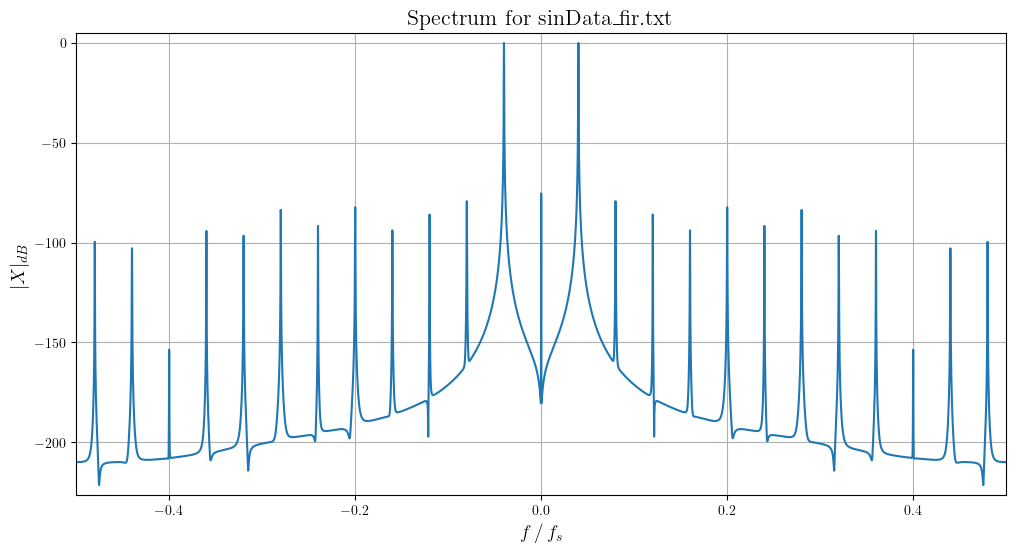

Processed real data from output/sinData_fir.txt
Processing file: output/sinDataComplex_fir.txt
{'file_name': 'sinDataComplex_fir.txt', 'contains_Complex': True, 'contains_LUT': False, 'OSR': 8.0, 'complex': 1.0, 'fs': 10000.0}
1
1
Saved spectrum plot to ./figs/sinDataComplex_fir_spectrum.png


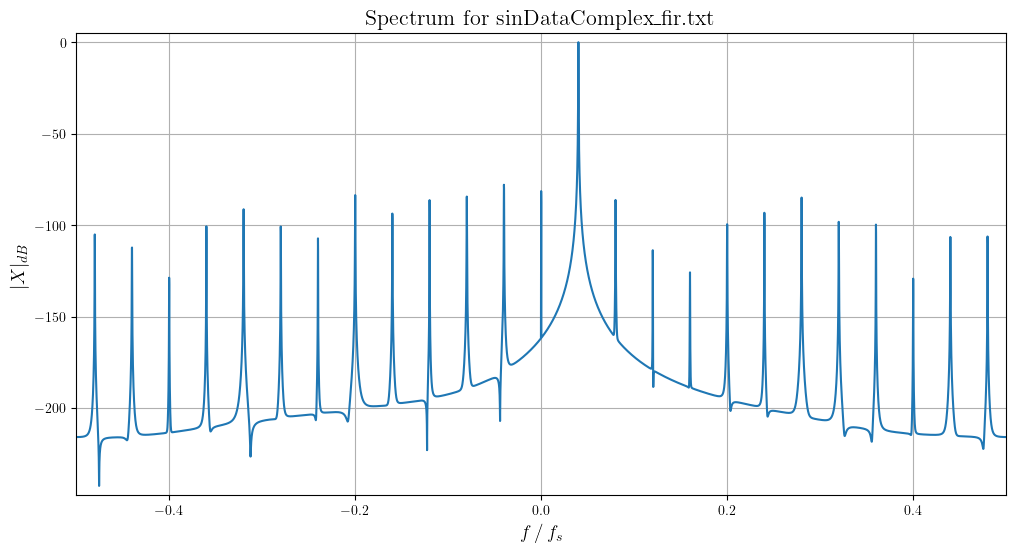

Processed complex data from output/sinDataComplex_fir.txt
Processing file: output/sinData_deltaSigma.txt
{'file_name': 'sinData_deltaSigma.txt', 'contains_Complex': False, 'contains_LUT': False, 'OSR': 8.0, 'complex': 0.0, 'fs': 10000.0}
1
1
Saved spectrum plot to ./figs/sinData_deltaSigma_spectrum.png


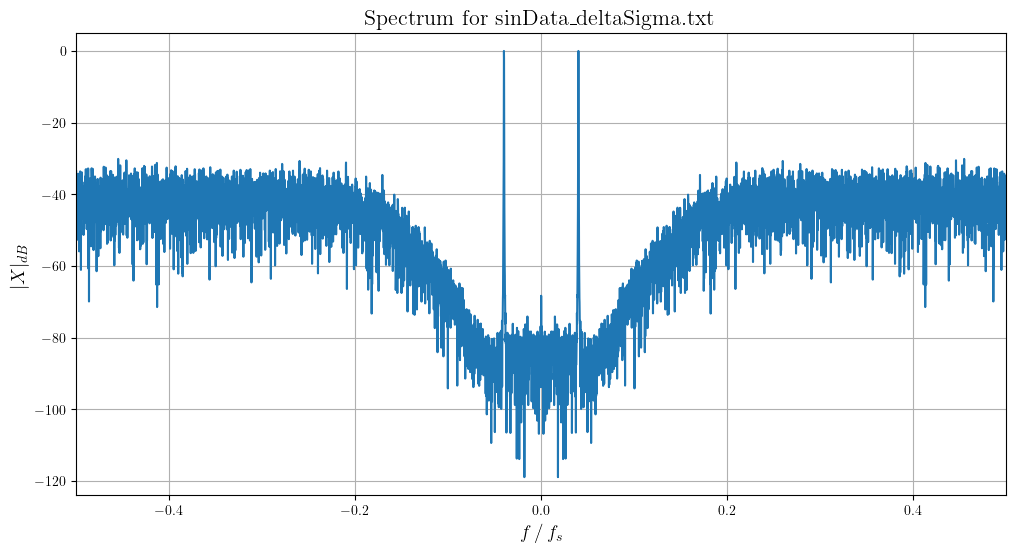

Processed real data from output/sinData_deltaSigma.txt
Processing file: output/sinDataComplex_deltaSigma.txt
{'file_name': 'sinDataComplex_deltaSigma.txt', 'contains_Complex': True, 'contains_LUT': False, 'OSR': 8.0, 'complex': 1.0, 'fs': 10000.0}
1
1
Saved spectrum plot to ./figs/sinDataComplex_deltaSigma_spectrum.png


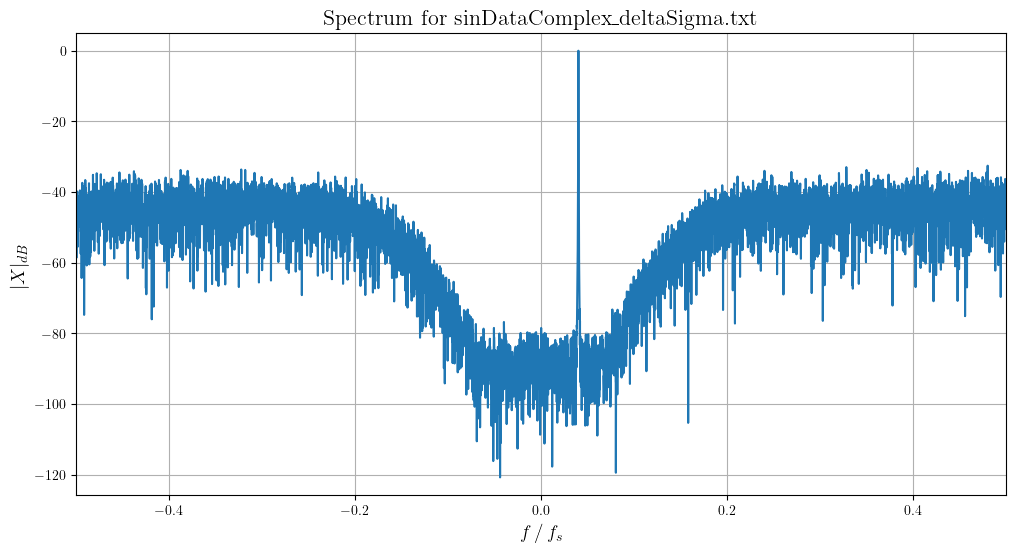

Processed complex data from output/sinDataComplex_deltaSigma.txt
Processing file: output/sinData_serial.txt
{'file_name': 'sinData_serial.txt', 'contains_Complex': False, 'contains_LUT': False, 'OSR': 8.0, 'complex': 0.0, 'fs': 10000.0, 'lut_width': 15.0}
15.0
15.0
Saved spectrum plot to ./figs/sinData_serial_spectrum.png


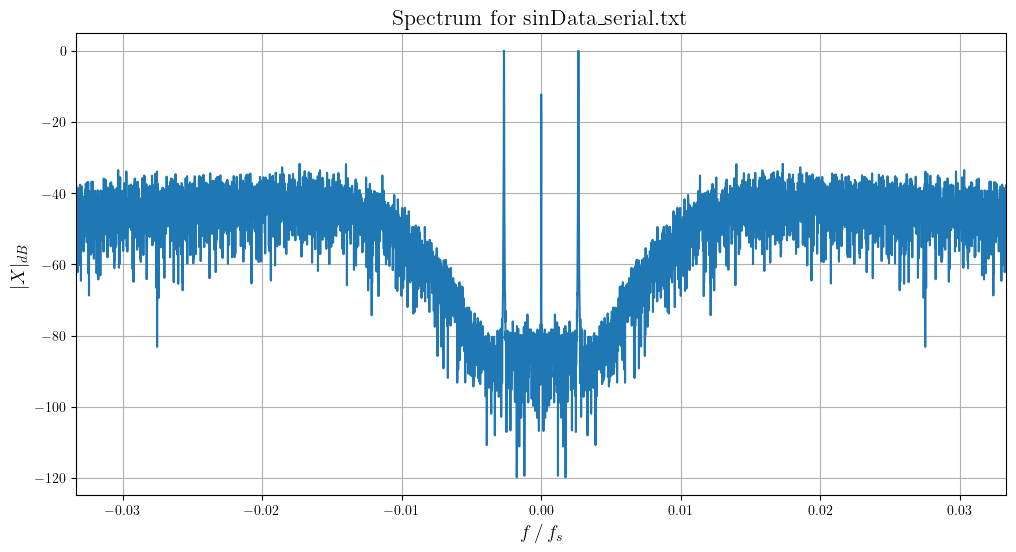

Processed real data from output/sinData_serial.txt
Processing file: output/sinDataComplex_serial.txt
{'file_name': 'sinDataComplex_serial.txt', 'contains_Complex': True, 'contains_LUT': False, 'OSR': 8.0, 'complex': 1.0, 'fs': 10000.0, 'lut_width': 15.0}
15.0
15.0
Saved spectrum plot to ./figs/sinDataComplex_serial_spectrum.png


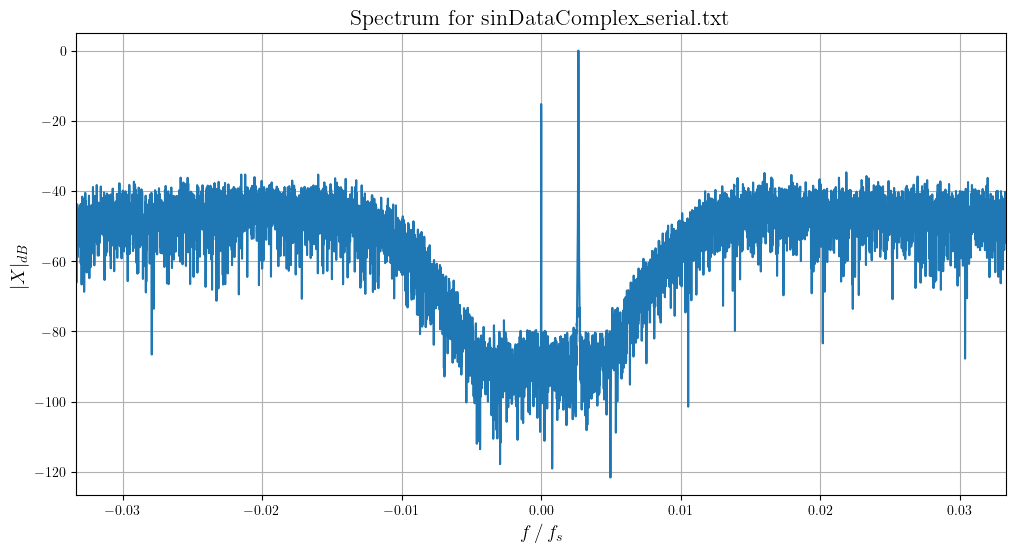

Processed complex data from output/sinDataComplex_serial.txt


In [13]:
#!/usr/bin/env python3

import os
import sys
import numpy as np
import scipy.signal as signal
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def read_file_with_header(file_path):
    """
    Reads a file with metadata in the header and numerical data below.
    Checks the filename for specific keywords like 'Complex' or 'LUT'.
    
    Args:
        file_path (str): Path to the input file.
    
    Returns:
        dict: Metadata key-value pairs, including file name details.
        np.ndarray: Numerical data as a NumPy array.
    """
    metadata = {}
    data = []

    # Extract the filename
    file_name = os.path.basename(file_path)
    metadata['file_name'] = file_name  # Store the filename in metadata

    # Check if the filename contains specific keywords
    metadata['contains_Complex'] = 'Complex' in file_name
    metadata['contains_LUT'] = 'LUT' in file_name

    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                key_value = line[1:].strip().split("=")  # Metadata in format `key=value`
                if len(key_value) == 2:
                    key, value = key_value[0].strip(), key_value[1].strip()
                    try:
                        # Convert numeric metadata to float if possible
                        metadata[key] = float(value) if value.replace('.', '', 1).isdigit() else value
                    except ValueError:
                        metadata[key] = value
            else:
                try:
                    # Read data based on metadata
                    if metadata.get('complex', 0) == 1:  # If complex metadata is 1
                        real, imag = map(float, line.strip().split())
                        data.append(complex(real, imag))
                    else:  # If complex metadata is 0
                        data.append(float(line.strip()))
                except ValueError:
                    pass  # Ignore non-numeric lines

    return metadata, np.array(data)

def process_file(file_path):
    """
    Processes a single file, extracting metadata, computing the spectrum, and saving plots.
    
    Args:
        file_path (str): Path to the file.
    """
    print(f"Processing file: {file_path}")
    metadata, data = read_file_with_header(file_path)
    print(metadata)

    if not data.size:
        print(f"Warning: No valid numerical data found in {file_path}")
        return

    # Extract metadata
    OSR = int(metadata.get("OSR", 1))
    is_complex = metadata.get("complex", 0) == 1  # Check if the data is complex
    lut_width = metadata.get("lut_width", 1)

    # Compute the windowed data and spectrum
    print(lut_width)
    w = signal.windows.hann(len(data), False)
    data_win = data * w
    spectrum = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(data_win))))
    spectrum -= np.max(spectrum)
    freqs = (np.arange(len(data)) / len(data) - 0.5)

    # Plot the spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(freqs, spectrum, label="Spectrum")
    plt.title(f"Spectrum for {os.path.basename(file_path)}", fontsize=16)
    plt.xlabel(r"$f \, / \, f_s$", fontsize=14)
    plt.ylabel(r"$|X|_{dB}$", fontsize=14)

    print(lut_width)
    x_min = -0.5/lut_width
    x_max = 0.5/lut_width
    y_min = np.min(spectrum[int((x_min+0.5)*len(spectrum)):int((x_max+0.5)*len(spectrum))])
    y_max = np.max(spectrum[int((x_min+0.5)*len(spectrum)):int((x_max+0.5)*len(spectrum))])

    plt.xlim([x_min, x_max])
    plt.ylim(y_min - 5, y_max + 5)

    plt.grid()

    # Save the figure
    file_name = os.path.basename(file_path).replace('.txt', '_spectrum.png')
    fig_path = os.path.join("./figs", file_name)
    plt.savefig(fig_path)
    print(f"Saved spectrum plot to {fig_path}")
    # plt.close()
    plt.show();

    # Additional printout for complex vs real
    data_type = "complex" if is_complex else "real"
    print(f"Processed {data_type} data from {file_path}")

def main():
    file_path = "output/sinData_fir.txt"
    process_file(file_path)
    
    file_path = "output/sinDataComplex_fir.txt"
    process_file(file_path)
    
    file_path = "output/sinData_deltaSigma.txt"
    process_file(file_path)

    file_path = "output/sinDataComplex_deltaSigma.txt"
    process_file(file_path)

    file_path = "output/sinData_serial.txt"
    process_file(file_path)

    file_path = "output/sinDataComplex_serial.txt"
    process_file(file_path)

if __name__ == "__main__":
    main()


In [1]:
import numpy as np
import scipy.signal as signal
from remezlp import *

N = 1024
Fmax = 0.4
Fpass = Fmax
Fstop = 1 - Fpass
AdB = 40
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, nPoints=N, Nmax=500)

TypeError: remez() takes 3 positional arguments but 4 were given

In [9]:

firResponse = [1.0, 1.0, 0, 0]
firFreqs = [0, 0.2, 0.3, 0.5]
firCoeff = signal.firls(5, firFreqs, firResponse, fs=1)
print(firCoeff)

[-2.63665205e-17  3.06687619e-01  5.00000000e-01  3.06687619e-01
 -2.63665205e-17]
